In [10]:
import numpy as np
import glob
import nibabel as nib
import os
import random
import h5py
import shutil
from multiprocessing import Pool
import pickle
import matplotlib.pyplot as plt

## Load MICCAI dataset

In [20]:
def load_miccai(path, num_files_to_load=float('inf'), n_zero_ratio = 0.1): # 
    data_list = glob.glob(nii_path + '*.nii.gz')[:num_files_to_load]
    data = []
    for file in data_list:
        img = nib.load(file).get_fdata()
        #img = img / np.max(img)
        for vol in range(img.shape[3]):
            for slc in range(img.shape[2]):
                if np.count_nonzero(img[:, :, slc, vol]) / np.prod(img[:, :, slc, vol].shape) >= n_zero_ratio:
                    data.append(img[:, :, slc, vol].reshape(img.shape[0], img.shape[1], 1))            
    return np.array(data)

In [27]:
def train_data_aug(train_gt):
    gt1= train_gt[0:13461,:,:]
    gt2a= train_gt[12471:12966,:,:] # overlapping data
    gt2b= train_gt[12966:13461,:,:] # overlapping data
    gt3a= train_gt[13461:16629,:,:] # non-overlapping data
    gt3b= train_gt[16629:19797,:,:] # non-overlapping data

    gt2=np.vstack((gt2a, gt2b))
    gt3=np.vstack((gt3a, gt3b))
    gt4 = np.vstack((gt2, gt3))
    gt_new=np.vstack((gt1, gt4))

    return gt_new

In [30]:
nii_path = '../datasets/MICCAI-2013-SATA-Challenge-Data/canine-legs/training-images/'
imgs = load_miccai(nii_path, num_files_to_load=3)
train_gt_aug = train_data_aug(imgs)

with open(os.path.join('./', 'training_gt_aug.pickle'), 'wb') as f:
    pickle.dump(train_gt_aug, f, protocol=4)

## Undersampling K-Space

Text(0.5, 1.0, 'Mask for Undersampling')

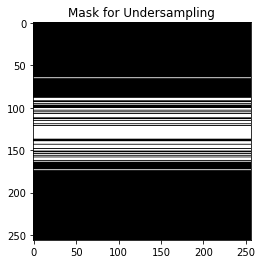

In [22]:
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

with open('./masks/mask_1dg_a5.pickle', 'rb') as f:
    mask = pickle.load(f)

plt.imshow(mask, cmap='gray')
plt.title('Mask for Undersampling')

In [23]:
def unsample_data(data, mask, accelaration_factor=5):
    uns_data = []
    for i in range(data.shape[0]):
        fourier = np.fft.fft2(data[i,:,:])
        cen_fourier  = np.fft.fftshift(fourier)
        subsam_fourier = np.multiply(cen_fourier,mask) # undersampling in k-space
        uncen_fourier = np.fft.ifftshift(subsam_fourier)
        zro_image = np.fft.ifft2(uncen_fourier) # zero-filled reconstruction
        uns_data.append(zro_image)        
    return np.array(uns_data)

def unsample_data_add_noise(data, mask, noise_ratio, accelaration_factor=5):
    fft_data = []
    uns_data = []
    for i in range(data.shape[0]):
        fourier = np.fft.fft2(data[i,:,:])
        cen_fourier  = np.fft.fftshift(fourier)
        fft_data.append(cen_fourier)
    fft_data = np.array(fft_data)
    fft_std = np.std(fft_data)
    
    nstd = (noise_ratio*fft_std)/np.sqrt(2)
    insh = (fft_data.shape[1],fft_data.shape[2])
    
    for i in range(fft_data.shape[0]):    
        fft_noise=fft_data[i,:,:]+np.random.normal(0,nstd,insh)+1j*np.random.normal(0,nstd,insh) #adding noise
        subsam_fourier = np.multiply(fft_noise,mask) # undersampling in k-space
        uncen_fourier = np.fft.ifftshift(subsam_fourier)
        zro_image = np.fft.ifft2(uncen_fourier) # zero-filled reconstruction
        uns_data.append(zro_image) 
        
    return np.array(uns_data)

In [ ]:
train_path = './training_gt_aug.pickle'
trf = open(train_path, 'rb')
train_data = pickle.load(trf)

train_data_new = unsample_data(train_data[0:13461,:,:], mask) # no noise
train_data_new2 = unsample_data_add_noise(train_data[13461:13956,:,:], mask, 0.1) # 10% noise-overlapping
train_data_new3 = unsample_data_add_noise(train_data[13956:14451,:,:], mask, 0.2) # 20% noise-overlapping
train_data_new4 = unsample_data_add_noise(train_data[14451:17619,:,:,], mask, 0.1) # 10% noise-nonoverlapping
train_data_new5 = unsample_data_add_noise(train_data[17619:20787,:,:], mask, 0.2) # 20% noise-nonoverlapping

stack1 = np.vstack((train_data_new, train_data_new2))
stack2 = np.vstack((train_data_new3, train_data_new4))
stack3 = np.vstack((stack2, train_data_new5))
fstack = np.vstack((stack1, stack3))

with open(os.path.join('./', 'training_usamp_1dg_a5_aug.pickle'), 'wb') as f:
    pickle.dump(fstack, f, protocol=4)

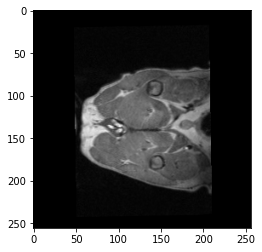

In [20]:
plt.imshow(train_data[100], cmap='gray')

In [ ]:
plt.imshow(fstack[100], cmap='gray')